In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import simplstyles
from fontTools.ttLib.woff2 import bboxFormat
from matplotlib import pyplot as plt
from matplotlib.patches import bbox_artist
from numpy.random import weibull
from seaborn import lineplot
from voxelwise_tutorials.io import load_hdf5_array
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

from compare_variance_residual.fmri.features import get_pretty_feature_name
from compare_variance_residual.fmri.results import get_result_path

In [3]:
data_dir = "../../data"
plt.style.use("nord-light-talk")
simplstyles

<module 'simplstyles' from '/home/leo/.virtualenvs/compare_variance_residual/lib/python3.12/site-packages/simplstyles/__init__.py'>

In [4]:
subject = 5
modality = 'listening'
low_level_features = ["phonemes", "powspec"]

In [5]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
mapper = load_hdf5_array(mapper_path)
flatmap_mask = mapper["flatmap_mask"]
mapper.keys()

dict_keys(['flatmap_curvature', 'flatmap_mask', 'flatmap_rois', 'roi_mask_AC', 'roi_mask_Broca', 'roi_mask_EBA', 'roi_mask_FEF', 'roi_mask_FFA', 'roi_mask_FO', 'roi_mask_IPS', 'roi_mask_M1F', 'roi_mask_M1H', 'roi_mask_M1M', 'roi_mask_OFA', 'roi_mask_OPA', 'roi_mask_PMvh', 'roi_mask_PPA', 'roi_mask_RSC', 'roi_mask_S1F', 'roi_mask_S1H', 'roi_mask_S1M', 'roi_mask_S2F', 'roi_mask_SEF', 'roi_mask_SMFA', 'roi_mask_SMHA', 'roi_mask_V1', 'roi_mask_V2', 'roi_mask_V3', 'roi_mask_iTPJ', 'roi_mask_sPMv', 'roi_mask_sPMv2', 'voxel_to_flatmap_data', 'voxel_to_flatmap_indices', 'voxel_to_flatmap_indptr', 'voxel_to_flatmap_shape', 'voxel_to_fsaverage_data', 'voxel_to_fsaverage_indices', 'voxel_to_fsaverage_indptr', 'voxel_to_fsaverage_shape'])

# mask out early ac

In [6]:
semantic_listening_path = os.path.join(get_result_path('listening', subject), "english1000_scores.csv")
semantic_reading_path = os.path.join(get_result_path('reading', subject), "english1000_scores.csv")

semantic_listening = pd.read_csv(semantic_listening_path)
semantic_reading = pd.read_csv(semantic_reading_path)

semantic_listening_corr = np.array(semantic_listening["correlation_score"])
semantic_reading_corr = np.array(semantic_reading["correlation_score"])

In [7]:
powspec_listening_path = os.path.join(get_result_path('listening', subject), "powspec_scores.csv")
powspec_reading_path = os.path.join(get_result_path('reading', subject), "powspec_scores.csv")

powspec_listening = pd.read_csv(powspec_listening_path)
powspec_reading = pd.read_csv(powspec_reading_path)

powspec_listening_corr = np.array(powspec_listening["correlation_score"])
powspec_reading_corr = np.array(powspec_reading["correlation_score"])

In [8]:
ac_mask = mapper["roi_mask_AC"]
ac_mask = np.bool(ac_mask)

By subtracting activity predicted by semantic feature during reading from listening, only the early ac should contain positive values

In [9]:
listening_minus_reading = semantic_listening_corr - semantic_reading_corr
thresh = 0.1
subtract_semantic_early_ac_mask = listening_minus_reading > thresh
subtract_semantic_early_ac_mask = subtract_semantic_early_ac_mask & ac_mask

Values that are high in one and low in the other

In [10]:
thresh_semantic_early_ac_mask = (semantic_listening_corr > thresh) & (semantic_reading_corr < thresh)
thresh_semantic_early_ac_mask = thresh_semantic_early_ac_mask & ac_mask

try the same for the spectral feature

In [11]:
subtract_powspec_early_ac_mask = (powspec_listening_corr - powspec_reading_corr) > thresh
subtract_powspec_early_ac_mask = subtract_powspec_early_ac_mask & ac_mask

In [12]:
thresh_powspec_early_ac_mask = (powspec_listening_corr > thresh) & (powspec_reading_corr < thresh)
thresh_powspec_early_ac_mask = thresh_powspec_early_ac_mask & ac_mask

Using EV

In [13]:
ev_listening = np.loadtxt(get_result_path('listening', subject) + "/ev.csv", delimiter=",", skiprows=1)
ev_reading = np.loadtxt(get_result_path('reading', subject) + "/ev.csv", delimiter=",", skiprows=1)

In [14]:
subtract_ev_early_ac_mask = ev_listening - ev_reading
thresh = 0.1
subtract_ev_early_ac_mask = subtract_ev_early_ac_mask > thresh
subtract_ev_early_ac_mask = subtract_ev_early_ac_mask & ac_mask

In [15]:
thresh_ev_early_ac_mask = (ev_listening > thresh) & (ev_reading < thresh)
thresh_ev_early_ac_mask = thresh_ev_early_ac_mask & ac_mask

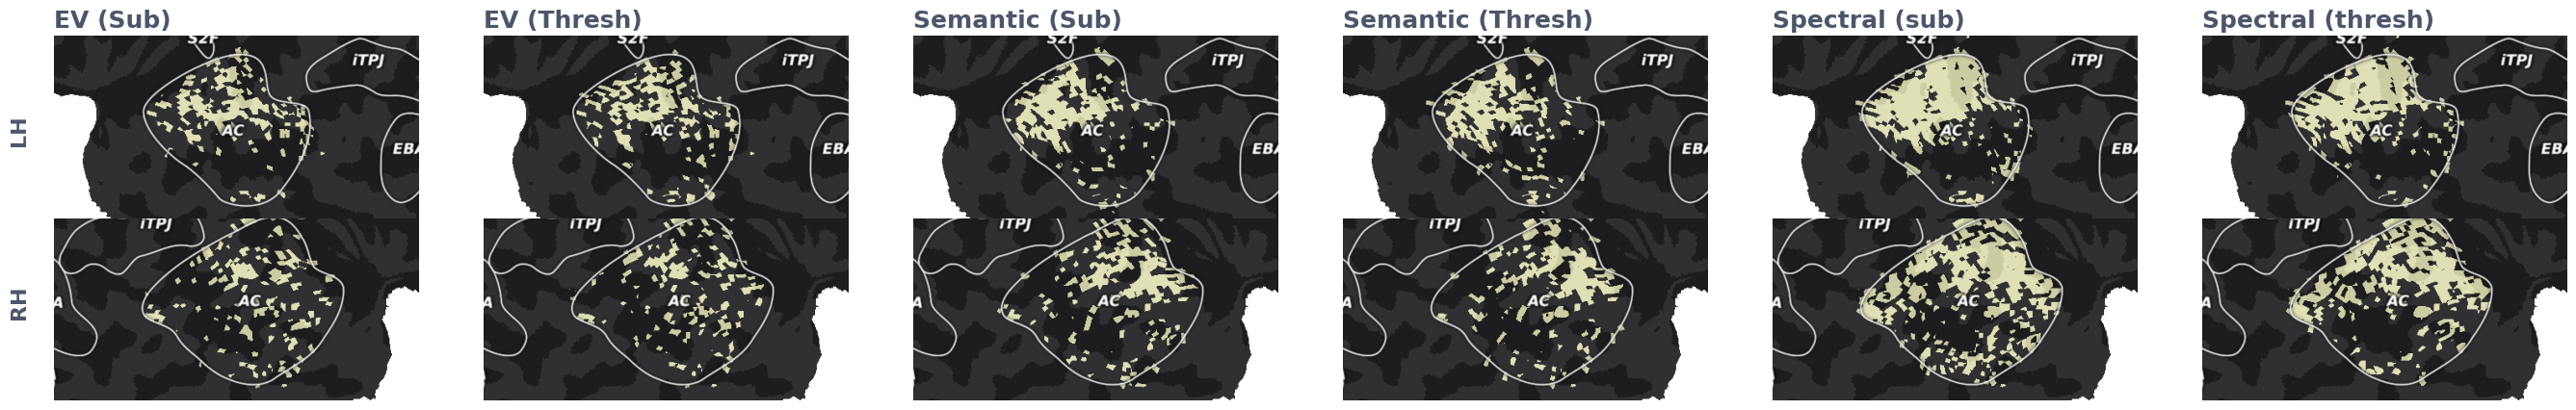

In [16]:
viewport_size = 450
fig, axs = plt.subplots(2, 6, figsize=(viewport_size / 100 * 6, viewport_size / 100))

cmap = 'magma'
alpha = 0.7

width = flatmap_mask.shape[0]
height = flatmap_mask.shape[1]
vcenter = 2 * height / 3
hcenter = width / 2

left_ac = hcenter - 500
right_ac = hcenter + 450
vac = 650

for row, ac in enumerate([left_ac, right_ac]):
    for col, (corr, name) in enumerate(
            zip([subtract_ev_early_ac_mask, thresh_ev_early_ac_mask, subtract_semantic_early_ac_mask,
                 thresh_semantic_early_ac_mask, subtract_powspec_early_ac_mask, thresh_powspec_early_ac_mask],
                ["EV (Sub)", "EV (Thresh)", "Semantic (Sub)", "Semantic (Thresh)", "Spectral (sub)",
                 "Spectral (thresh)"])):
        ax = axs[row, col]

        ax.axis('off')
        ax.set_xlim([ac - viewport_size / 2, ac + viewport_size / 2])
        ax.set_ylim([vac + viewport_size / 4, vac - viewport_size / 4])

        if row == 0:
            ax.set_title(name)

        plot_flatmap_from_mapper(corr, mapper_path, ax=ax, vmin=0, vmax=1, with_colorbar=False, cmap=cmap,
                                 alpha=alpha)

fig.text(0, .65, "LH", rotation=90, horizontalalignment='left', weight='bold')
fig.text(0, .25, "RH", rotation=90, horizontalalignment='left', weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

# Plot predicted activity in early ac

In [17]:
early_ac_mask = thresh_powspec_early_ac_mask

<Axes: >

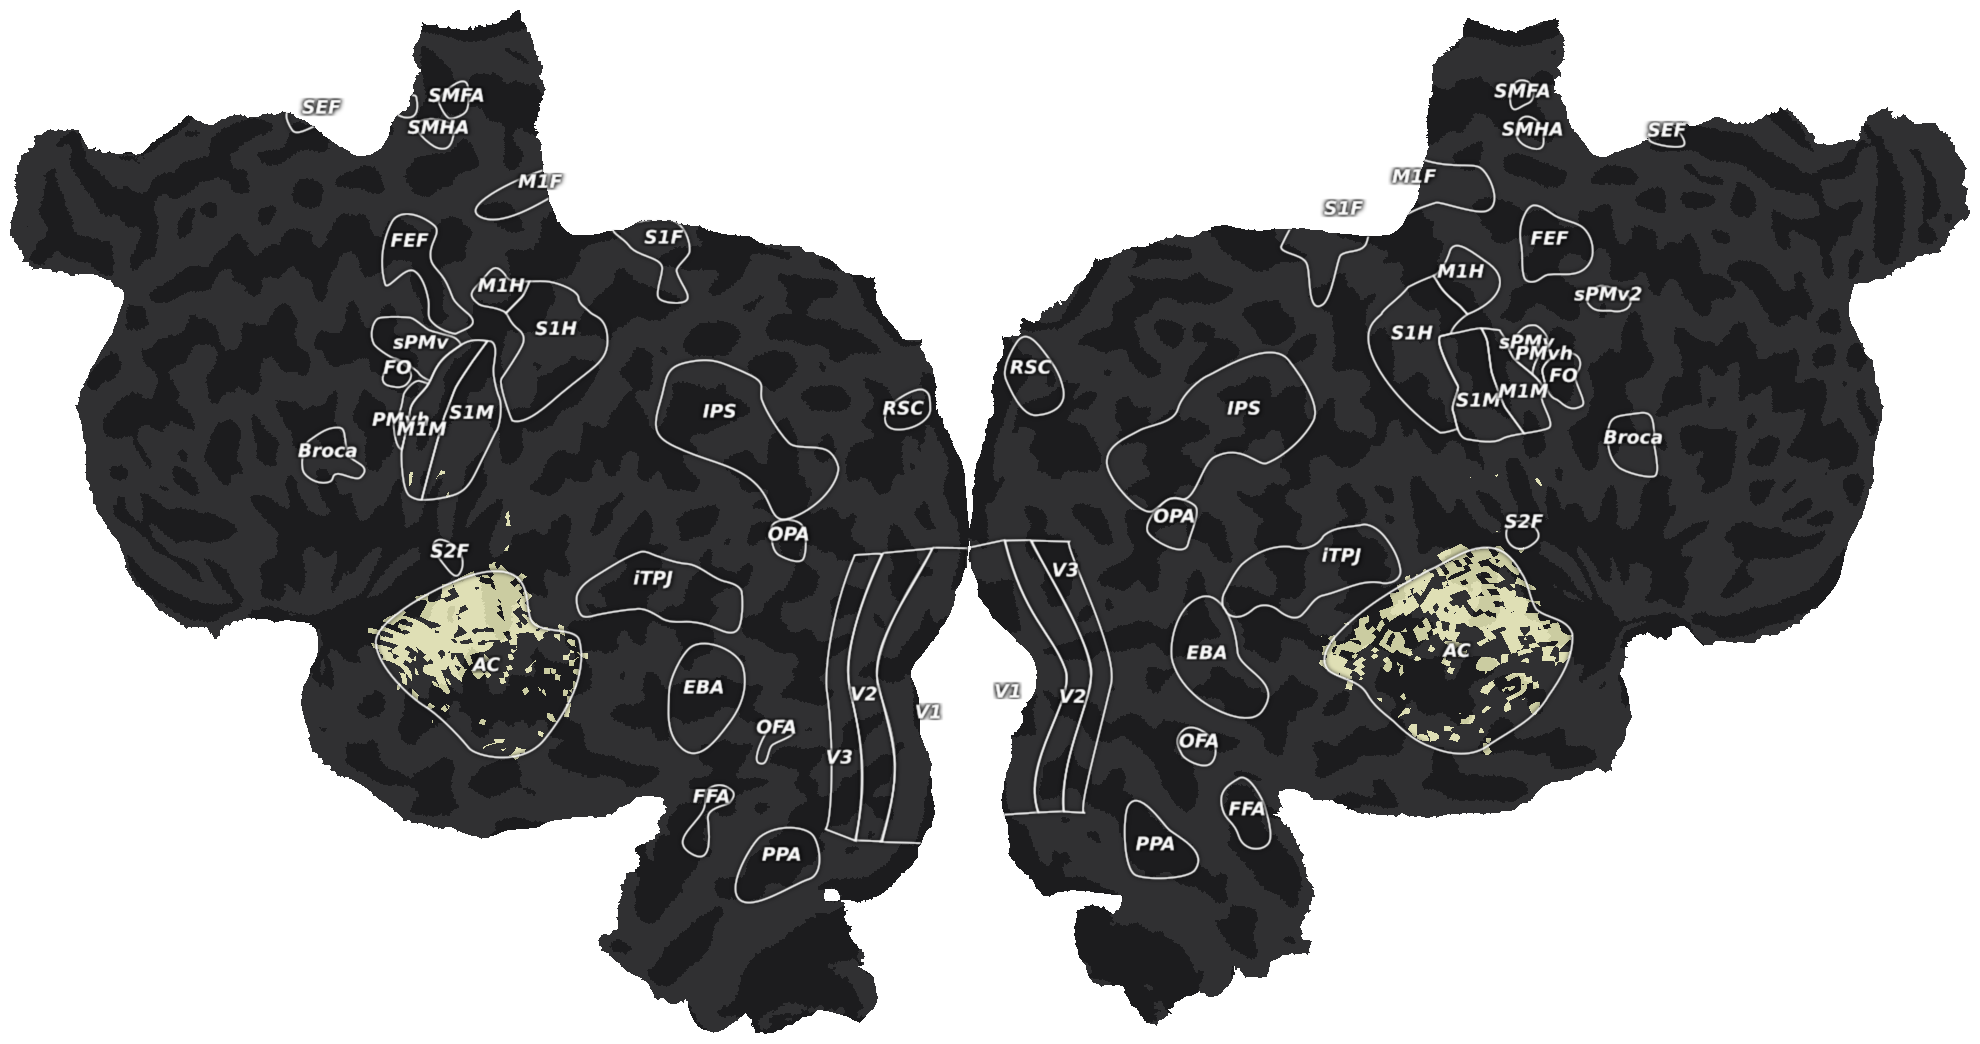

In [18]:
# viewport_size = 450
# fig, axs = plt.subplots(2, 1, figsize=(viewport_size / 100 * 1, viewport_size / 100))
# 
# cmap = 'magma'
# alpha = 0.7
# 
# width = flatmap_mask.shape[0]
# height = flatmap_mask.shape[1]
# vcenter = 2 * height / 3
# hcenter = width / 2
# 
# left_ac = hcenter - 500
# right_ac = hcenter + 450
# vac = 650
# 
# for row, ac in enumerate([left_ac, right_ac]):
#     ax = axs[row]
# 
#     ax.axis('off')
#     ax.set_xlim([ac - viewport_size / 2, ac + viewport_size / 2])
#     ax.set_ylim([vac + viewport_size / 4, vac - viewport_size / 4])

plot_flatmap_from_mapper(early_ac_mask, mapper_path, vmin=0, vmax=1, with_colorbar=False, cmap=cmap,
                             alpha=alpha)

# fig.text(0, .65, "LH", rotation=90, horizontalalignment='left', weight='bold')
# fig.text(0, .25, "RH", rotation=90, horizontalalignment='left', weight='bold')
# 
# plt.tight_layout()
# plt.subplots_adjust(hspace=0)
# plt.show()

# Plot predicted activity in early ac

In [19]:
result_path = get_result_path(modality, subject)
semantic_path = os.path.join(result_path, "english1000_scores.csv")
vp_paths = []
rm_paths = []
rm_ridge_paths = []
for low_level_feature in low_level_features:
    vp_paths.append(os.path.join(result_path, f"vp_english1000_{low_level_feature}_scores.csv"))
    rm_paths.append(
        os.path.join(result_path, f"residual_{low_level_feature}_english1000_scores.csv"))
    rm_ridge_paths.append(
        os.path.join(result_path, f"residual_ridge_{low_level_feature}_english1000_scores.csv"))

In [20]:
semantic = pd.read_csv(semantic_path)
semantic_correlation = np.array(semantic["correlation_score"])

vp_correlations = []
rm_correlations = []
rm_ridge_correlations = []

for i, low_level_feature in enumerate(low_level_features):
    vp = pd.read_csv(vp_paths[i])
    rm = pd.read_csv(rm_paths[i])
    rm_ridge = pd.read_csv(rm_ridge_paths[i])

    vp_correlation = np.array(vp[f"semantic\\{low_level_feature}"])
    rm_correlation = np.array(rm[f"correlation_score"])
    rm_ridge_correlation = np.array(rm_ridge[f"correlation_score"])

    vp_correlations.append(vp_correlation)
    rm_correlations.append(rm_correlation)
    rm_ridge_correlations.append(rm_ridge_correlation)

In [21]:
# Create a DataFrame
datas = []

for i, low_level_feature in enumerate(low_level_features):
    data = pd.DataFrame({
        'Semantic': semantic_correlation[early_ac_mask],
        'Residual Method (ridge)': rm_ridge_correlations[i][early_ac_mask],
        'Residual Method (OLS)': rm_correlations[i][early_ac_mask],
        'Variance Partitioning': vp_correlations[i][early_ac_mask],
    })
    datas.append(data)
# Display the DataFrame
print(datas)

[     Semantic  Residual Method (ridge)  Residual Method (OLS)  \
0    0.078366                -0.017609              -0.023427   
1    0.021224                -0.033507              -0.035746   
2   -0.007083                 0.078736               0.080316   
3   -0.028763                -0.050497              -0.049508   
4    0.000640                 0.032087               0.035706   
..        ...                      ...                    ...   
747  0.134104                -0.076562              -0.085450   
748  0.145642                 0.134193               0.131132   
749 -0.020182                -0.012601              -0.011591   
750  0.055964                -0.059105              -0.062861   
751  0.017613                 0.061775               0.064478   

     Variance Partitioning  
0                 0.021900  
1                -0.000021  
2                 0.000125  
3                -0.029020  
4                 0.000269  
..                     ...  
747            

In [22]:
print(datas[0])

     Semantic  Residual Method (ridge)  Residual Method (OLS)  \
0    0.078366                -0.017609              -0.023427   
1    0.021224                -0.033507              -0.035746   
2   -0.007083                 0.078736               0.080316   
3   -0.028763                -0.050497              -0.049508   
4    0.000640                 0.032087               0.035706   
..        ...                      ...                    ...   
747  0.134104                -0.076562              -0.085450   
748  0.145642                 0.134193               0.131132   
749 -0.020182                -0.012601              -0.011591   
750  0.055964                -0.059105              -0.062861   
751  0.017613                 0.061775               0.064478   

     Variance Partitioning  
0                 0.021900  
1                -0.000021  
2                 0.000125  
3                -0.029020  
4                 0.000269  
..                     ...  
747             

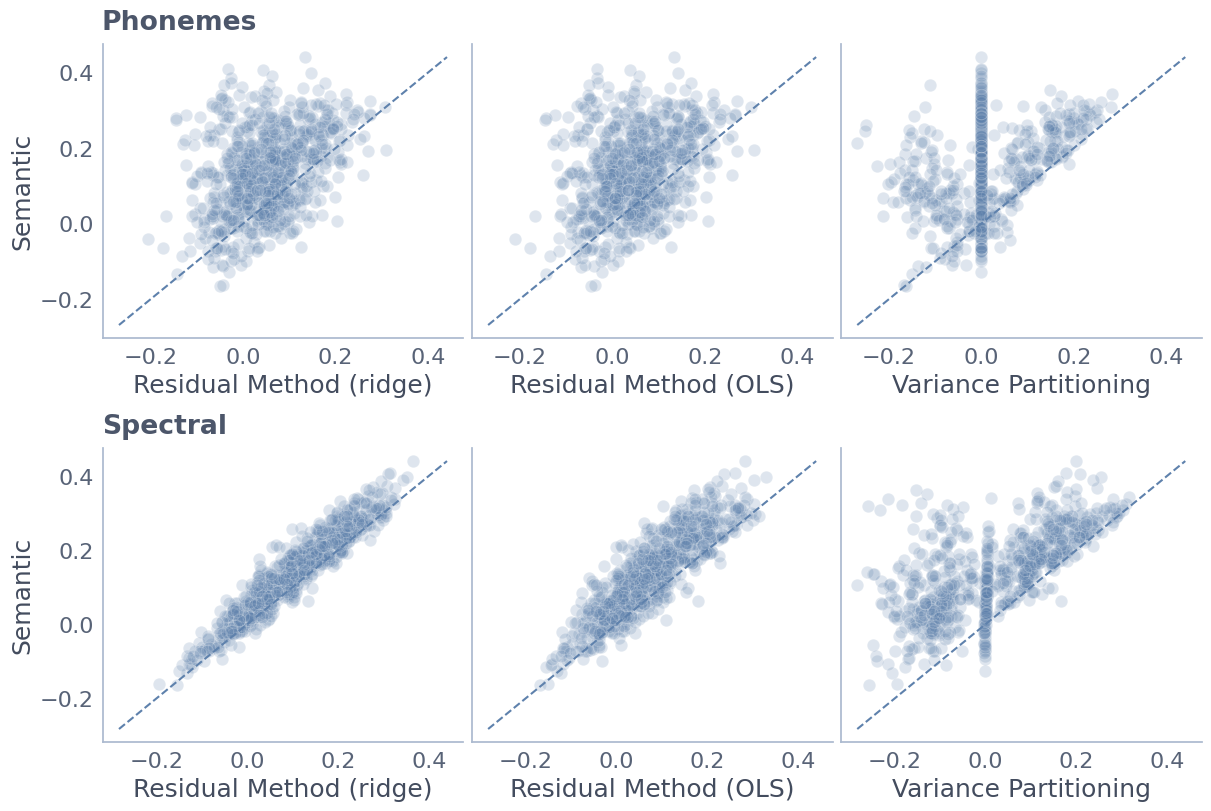

In [23]:
# create 3x1 subplots
fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(12, 8))

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, (subfig, low_level_feature) in enumerate(
        zip(subfigs, low_level_features)):
    subfig.suptitle(get_pretty_feature_name(low_level_feature), weight='bold', x=0.08, horizontalalignment='left')
    _data = datas[row]
    vmin = _data.min().min()
    vmax = _data.max().max()

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
    for col, (ax, column) in enumerate(zip(axs, _data.columns[1:])):
        sns.scatterplot(_data, x=column, y="Semantic", ax=ax, alpha=0.2)
        sns.lineplot(x=[vmin, vmax], y=[vmin, vmax], linestyle='--', ax=ax)
        ax.plot()

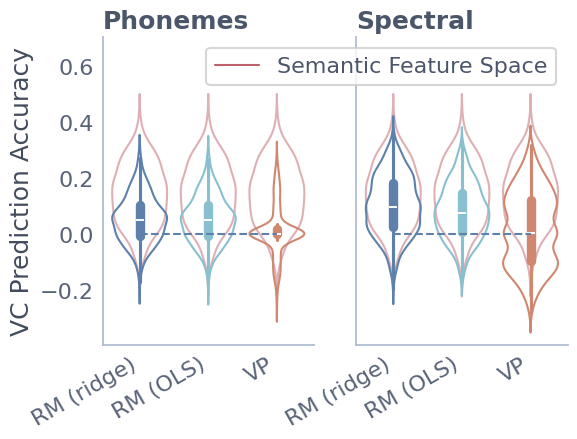

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)
vmax = 0


for i, (low_level_feature, feature_name) in enumerate(zip(low_level_features, ["Phonemes", "Spectral"])):

    _data = datas[i]
    _data.columns = ["Semantic", "RM (ridge)", "RM (OLS)", "VP"]
    vmax = max(_data.max().max(), vmax)

    for j, (column, color) in enumerate(zip(_data.columns[1:], ["C0", "C1", "C2"])):
        sns.violinplot(_data, x=j, y="Semantic", ax=axs[i], color="C3", fill=False, alpha=0.5, inner=None)
        sns.violinplot(_data, x=j, y=column, color=color, fill=False, ax=axs[i])

    axs[i].set_xticks(range(3), _data.columns[1:], rotation=30, ha="right")
    axs[i].set_title(feature_name)
    # plt.axhline(0, linestyle="--", ax=axs[i])
    axs[i].hlines(0, 0, 2, linestyle='--')

plt.plot([0,0], [0,0], label="Semantic Feature Space", color="C3")
axs[0].set_ylabel("VC Prediction Accuracy")

for ax in axs:
    ax.set_ylim(ax.get_ylim()[0], vmax + vmax * 0.6)

plt.legend(bbox_to_anchor=(1., 1.0), loc="upper right", frameon=True)

Text(0, 0.5, 'VC Prediction Accuracy')

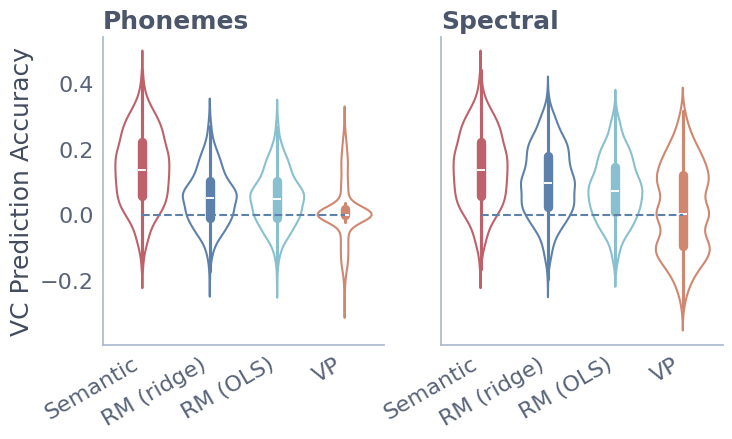

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for i, (low_level_feature, feature_name) in enumerate(zip(low_level_features, ["Phonemes", "Spectral"])):

    _data = datas[i]
    _data.columns = ["Semantic", "RM (ridge)", "RM (OLS)", "VP"]

    for j, (column, color) in enumerate(zip(_data.columns, ["C3", "C0", "C1", "C2"])):
        sns.violinplot(_data, x=j, y=column, color=color, fill=False, ax=axs[i])

    axs[i].set_xticks(range(4), _data.columns, rotation=30, ha="right")
    axs[i].set_title(feature_name)
    axs[i].hlines(0, 0, 3, linestyle='--')

axs[0].set_ylabel("VC Prediction Accuracy")
# plt.tight_layout()

Text(0, 0.5, 'Semantic - Predicted')

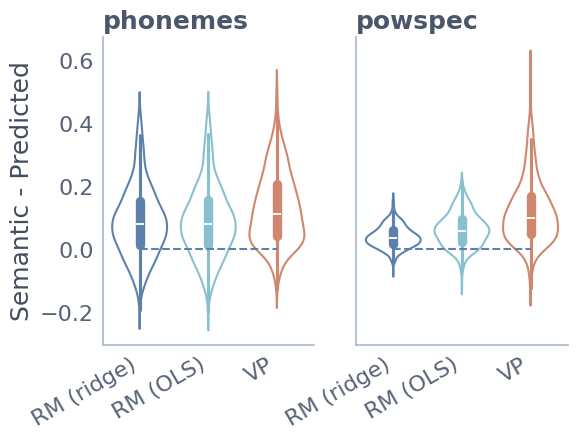

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)

for i, low_level_feature in enumerate(low_level_features):
    _data = datas[i]
    data_removed = _data.iloc[:, 1:].apply(lambda x: _data.iloc[:, 0] - x)
    data_removed.columns = ["RM (ridge)", "RM (OLS)", "VP"]

    for j, (column, color) in enumerate(zip(data_removed.columns, ["C0", "C1", "C2"])):
        sns.violinplot(data_removed, x=j, y=column, color=color, fill=False, ax=axs[i])

    axs[i].set_xticks(range(3), data_removed.columns, rotation=30, ha="right")
    axs[i].set_title(low_level_feature)
    axs[i].hlines(0, 0, 2, linestyle='--')

    plt.xticks(range(3), data_removed.columns, rotation=30, ha="right")
axs[0].set_ylabel("Semantic - Predicted")